In [1]:
import numpy as np
import pandas as pd

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, roc_auc_score


# load pytorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary



import matplotlib.pyplot as plt
import seaborn as sns 
sns.set(style="whitegrid", font_scale=1.3)


# Load & Scale Datasetes

In [2]:
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X1 = scaler.fit_transform(load_breast_cancer()['data'])
y1 = load_breast_cancer()['target']

In [3]:
data2 = pd.read_csv('cleaned_german_credit_data.csv', index_col=0)
X2 = data2.drop('Risk',1 ).values
X2 = scaler.fit_transform(X2)

y2 = data2.Risk.values

/home/vadim/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/vadim/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [4]:
data3 = pd.read_csv('wine_data.csv', delim_whitespace=1)

def quality_to_binary(x):
    '''
    convert multiclass problem into binary
    '''
    if x > 5:
        return 1
    else:
        return 0

data3['quality'] = data3['quality'].apply(quality_to_binary)
data3['Type'], _ = pd.factorize(data3['Type'])
X3 = scaler.fit_transform(data3.drop('quality',1))
y3 = data3.quality.values

/home/vadim/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/vadim/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


# CancelOut Layer 

In [5]:
class CancelOut(nn.Module):
    '''
    Cancel Out Layer
    
    '''
    def __init__(self,inp, *kargs, **kwargs):
        super(CancelOut, self).__init__()
        self.weights = nn.Parameter(torch.zeros(inp,requires_grad = True))
    def forward(self, x):
        return (x * torch.sigmoid(self.weights.float()) )

In [6]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.my = CancelOut(input_size)
        self.fc2 = nn.Linear(hidden_size,hidden_size)
        self.fc3 = nn.Linear(hidden_size,num_classes)

    def forward(self, x):
        x = self.my(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)

        return x

class myDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    def __len__(self):
        return len(self.X)

In [7]:
def train_ann(X,y,num_epochs):
    model = NeuralNet(X.shape[1],10,2)
    print("Deep Learning Model Summary")
    summary(model, (1, X.shape[1]))
    print("---------------------------")

    mydataset = myDataset(X,y)
    batch_size = 32 
    learning_rate = 0.1
    train_loader = torch.utils.data.DataLoader(dataset=mydataset,
                                               batch_size=batch_size, 
                                               shuffle=True)
    criterion = nn.CrossEntropyLoss()  
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  
    for epoch in range(num_epochs):
        for i, (sample, labels) in enumerate(train_loader):
            # Forward pass
            outputs = model(sample.float())
            loss = criterion(outputs, labels) #+ reg
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return list(model.my.parameters())[0].detach().numpy()

In [8]:
def CV_test(X,y):
    '''
    StratifiedKFold Cross-Validation 
    '''
    score = []
    for i in range(11,23,2):
        cv = StratifiedKFold(5, random_state=i+100)
        clf = KNeighborsClassifier(n_neighbors=i+2,n_jobs=-1)
        score.append(cross_val_score(clf, X, y,cv=cv, scoring=make_scorer(roc_auc_score)).mean())
    return np.mean(score)

def compare_fi(X,y,d, debug=False):
    '''
    Compare feature selection methods
    '''
    nn_lst = []
    gb_list = []
    acc_nn, acc_gg = [], []
    
    for f_nn, f_gb in zip(d['nn'], d['gb']):
        nn_lst.append(f_nn)
        gb_list.append(f_gb)
        if debug:
            print(nn_lst)
            print(gb_list)
        acc_nn.append(CV_test(X[:,nn_lst], y).mean())
        acc_gg.append(CV_test(X[:,gb_list], y).mean())
    return acc_nn, acc_gg

def feature_extraction(X, y, f_number):
    
    feature_weights = {}
    # Gradient Boosting FS
    forest = GradientBoostingClassifier(n_estimators=250,random_state=0)
    forest.fit(X, y)
    gb_importances = forest.feature_importances_
    
    # NN FS
    cancelout_weights_importance = train_ann(X,y,100)
    print("CancelOut weights:")
    print(cancelout_weights_importance,'\n')
    # selecting first 5 features 
    feature_weights['nn'] = cancelout_weights_importance.argsort()[::-1]
    feature_weights['gb'] = gb_importances.argsort()[::-1]
    nn_fi = cancelout_weights_importance.argsort()[-f_number:][::-1]
    gb_fi = gb_importances.argsort()[-f_number:][::-1]
    
    print('Feauters selected using ANN with CancelOut', sorted(nn_fi))
    print('Feature selected using GB ',sorted(gb_fi))
    
    print(f'CV score from all features: {CV_test( X, y)}')
    print(f'CV score GB FS: {CV_test(X[:,gb_fi], y)}')
    print(f'CV score NN FS: {CV_test(X[:,nn_fi], y)}')
    
    return feature_weights


def TestBench(X,y):
    d = feature_extraction(X, y, 5)
    acc_nn, acc_gg = compare_fi(X,y, d, debug=False)
    plt.plot(np.array(acc_gg), 'r', label='FS using GradientBoosting')
    plt.plot(np.array(acc_nn), 'g', label='FS using NN with CancelOut layer')
    plt.legend(loc='best')
    plt.xlabel('Number of Features')
    plt.ylabel('AUC')
    plt.xlim(1, X.shape[1]-1)
    plt.tight_layout()

    


Deep Learning Model Summary
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         CancelOut-1                [-1, 1, 30]               0
            Linear-2                [-1, 1, 10]             310
              ReLU-3                [-1, 1, 10]               0
            Linear-4                [-1, 1, 10]             110
              ReLU-5                [-1, 1, 10]               0
            Linear-6                 [-1, 1, 2]              22
Total params: 442
Trainable params: 442
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------
---------------------------
CancelOut weights:
[ 0.6263898   0.21537022  0.57783663 -1.5470868  -2.828194   -2.7525103
 -1.9992304   3.0710573  -1.548

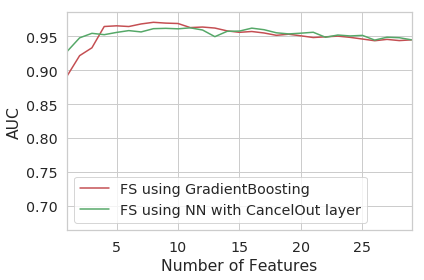

In [9]:
torch.manual_seed(0)

TestBench(X1,y1)

Deep Learning Model Summary
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         CancelOut-1                [-1, 1, 23]               0
            Linear-2                [-1, 1, 10]             240
              ReLU-3                [-1, 1, 10]               0
            Linear-4                [-1, 1, 10]             110
              ReLU-5                [-1, 1, 10]               0
            Linear-6                 [-1, 1, 2]              22
Total params: 372
Trainable params: 372
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------
---------------------------
CancelOut weights:
[ 4.1419373e+00  2.1135540e+00  4.8430204e-01  6.0381060e+00
  4.3740740e+00  5.1141077e-01  5.2208767e

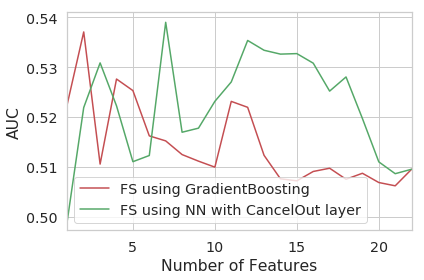

In [10]:
torch.manual_seed(0)

TestBench(X2,y2)

Deep Learning Model Summary
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         CancelOut-1                [-1, 1, 12]               0
            Linear-2                [-1, 1, 10]             130
              ReLU-3                [-1, 1, 10]               0
            Linear-4                [-1, 1, 10]             110
              ReLU-5                [-1, 1, 10]               0
            Linear-6                 [-1, 1, 2]              22
Total params: 262
Trainable params: 262
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------
---------------------------
CancelOut weights:
[-3.4675112 -7.1627173  5.3528476 -4.7133737 -0.5145204 -6.9896235
 -1.7019093 -3.400412  -3.4627364 -5

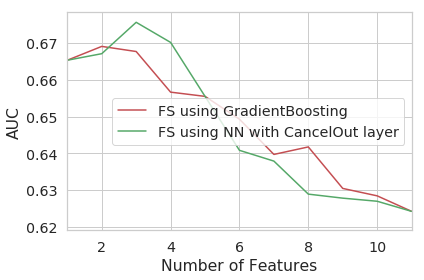

In [11]:
torch.manual_seed(0)

TestBench(X3,y3)